In [1]:
import glob
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot 
from astropy import units as u 
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.utils import calc_angular_separation

In [2]:
# --- ignore warnings ---
warnings.simplefilter('ignore')

# --- display all columns --- 
pd.set_option('display.max_columns', None)

# --- customize pyplot figure ---
pyplot.rcParams['figure.figsize'] = (12, 9)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['grid.linestyle'] = ':'

# --- get the default color cycle ---
color_cycle = pyplot.rcParams['axes.prop_cycle'].by_key()['color']

# Load DL2 data

In [3]:
data_path = '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/' \
            'dl2_lst1_magic_run03265_to_03268_merged.h5'

In [4]:
tel_combinations = {
    'm1_m2': [2, 3],   # event_type = 0
    'lst1_m1': [1, 2],   # event_type = 1
    'lst1_m2': [1, 3],   # event_type = 2
    'lst1_m1_m2': [1, 2, 3]   # event_type = 3
}

# --- load/merge the input data ---
print(f'Loading the input data file:\n{data_path}')

data_joint = pd.read_hdf(data_path, key='events/params')
data_joint.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_joint.sort_index(inplace=True)

# --- check the number of events ---
n_events_total = len(data_joint.groupby(['obs_id', 'event_id']).size()) 
print(f'\nIn total {n_events_total} stereo events:') 

for event_type, (tel_combo, tel_ids) in enumerate(tel_combinations.items()):

    df = data_joint.query(f'(tel_id == {tel_ids}) & (multiplicity == {len(tel_ids)})')
    df['multiplicity'] = df.groupby(['obs_id', 'event_id']).size()
    df.query(f'multiplicity == {len(tel_ids)}', inplace=True)
    
    n_events = len(df.groupby(['obs_id', 'event_id']).size())
    print(f'{tel_combo} (event type {event_type}): {n_events} events ({n_events / n_events_total * 100:.1f}%)')
    
    data_joint.loc[df.index, 'event_type'] = event_type
    
print('\nDone.')

Loading the input data file:
/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/dl2_lst1_magic_run03265_to_03268_merged.h5

In total 572205 stereo events:
m1_m2 (event type 0): 74553 events (13.0%)
lst1_m1 (event type 1): 52391 events (9.2%)
lst1_m2 (event type 2): 104442 events (18.3%)
lst1_m1_m2 (event type 3): 340819 events (59.6%)

Done.


In [5]:
data_joint.head(10)

obs_id_lst  event_id_lst   intensity         x  \
obs_id  event_id tel_id                                                   
5093711 1882     1           3265.0      213291.0  628.996461 -0.614424   
                 2              NaN           NaN  290.039062 -0.302226   
                 3              NaN           NaN  178.574219 -0.251598   
        1883     1           3265.0      213300.0   60.000429 -0.174285   
                 3              NaN           NaN   68.593750 -0.040102   
        1884     1           3265.0      213433.0  293.623596  0.507267   
                 3              NaN           NaN   52.742188  0.198661   
        1885     1           3265.0      213461.0  118.464108 -0.760221   
                 2              NaN           NaN  254.459636  0.128960   
                 3              NaN           NaN   90.601562 -0.249119   

                                y         r         phi    length     width  \
obs_id  event_id tel_id                                                       
5093711 1882     1       0.126387  0.627288  168.376396  0.075051  0.044849   
                 2       0.111699  0.322207  159.716245  0.052958  0.030104   
                 3       0.071062  0.261441  164.228178  0.148567  0.030572   
        1883     1      -0.365451  0.404883 -115.496606  0.030412  0.025393   
                 3      -0.245073  0.248332  -99.293091  0.020853  0.019717   
        1884     1      -0.260798  0.570381  -27.208751  0.074620  0.039984   
                 3      -0.168252  0.260337  -40.262227  0.025472  0.007890   
        1885     1      -0.109411  0.768054 -171.810199  0.048920  0.025192   
                 2       0.016244  0.129979    7.179275  0.049632  0.028849   
                 3      -0.226988  0.337022 -137.661337  0.029378  0.020410   

                               psi  skewness  kurtosis      slope  intercept  \
obs_id  event_id tel_id                                                        
5093711 1882     1      -11.077946 -0.472665  2.430437  -5.839979  16.659332   
                 2      -28.351680  0.022468  2.006568  -8.048335  24.880157   
                 3       12.571635  1.150621  2.533926 -15.539467  27.215714   
        1883     1      -39.888956  0.347079  1.937986  -7.553362  15.258784   
                 3      -44.689152  0.599909  3.394796  16.288925  23.731348   
        1884     1       78.509347 -0.123184  2.022596   2.491492  18.487489   
                 3      -17.319846 -0.041161  1.861422  20.921322  21.116408   
        1885     1       27.962136 -0.655231  2.913124  -0.801660  14.567327   
                 2       89.250261  0.179019  2.256203  -0.259531  23.936669   
                 3      -84.691631  0.416796  2.433162 -20.010247  25.044242   

                         intensity_width_1  intensity_width_2  pixels_width_1  \
obs_id  event_id tel_id                                                         
5093711 1882     1                     0.0                0.0             0.0   
                 2                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   
        1883     1                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   
        1884     1                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   
        1885     1                     0.0                0.0             0.0   
                 2                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   

                         pixels_width_2  n_pixels  n_islands   alt_tel  \
obs_id  event_id tel_id                                                  
5093711 1882     1                  0.0        27          1  0.699055   
                 2 

### Arrange the DL2 data frame

In [6]:
print('Arrange the data frame...')

params = ['ra_tel_mean', 'dec_tel_mean', 'reco_ra_mean', 'reco_dec_mean', 'dist_sum',
          'reco_energy_mean', 'gammaness_mean', 'timestamp', 'event_type']

data_dl2 = data_joint[params]
data_dl2 = data_dl2.groupby(['obs_id', 'event_id']).mean()
data_dl2.dropna(inplace=True)

# --- exclude M1+M2 events due to insufficient training sample ---
data_dl2.query('event_type != 0', inplace=True)

print(f'--> {len(data_dl2)} events')

Arrange the data frame...
--> 497652 events


In [7]:
data_dl2.head()

ra_tel_mean  dec_tel_mean  reco_ra_mean  reco_dec_mean  \
obs_id  event_id                                                           
5093711 1882        83.964756     22.247877     84.159162      22.042105   
        1883        83.964313     22.248447     84.175056      23.456163   
        1884        83.964314     22.248441     83.272619      23.462246   
        1885        83.964756     22.247873     84.132511      21.780393   
        1887        83.964314     22.248436     84.323590      23.461802   

                  dist_sum  reco_energy_mean  gammaness_mean     timestamp  \
obs_id  event_id                                                             
5093711 1882      1.252642          0.357103        0.273286  1.608068e+09   
        1883      0.035122          0.096436        0.795667  1.608068e+09   
        1884      0.407697          0.105428        0.493167  1.608068e+09   
        1885      3.173902          0.197106        0.010667  1.608068e+09   
        1887      0.198727          0.169970        0.047583  1.608068e+09   

                  event_type  
obs_id  event_id              
5093711 1882             3.0  
        1883             2.0  
        1884             2.0  
        1885             3.0  
        1887             2.0

# Calculate angular separation

Observation ID: 5093711


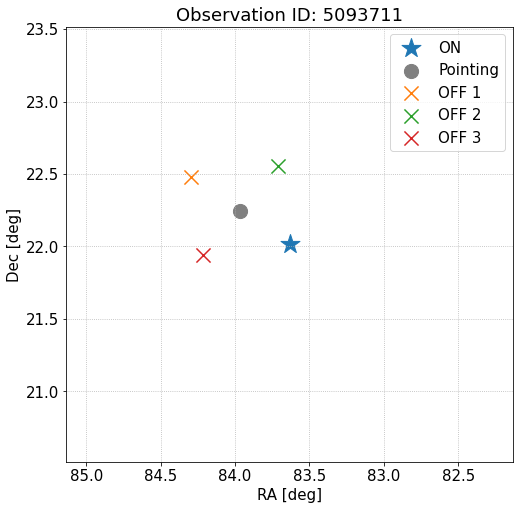

Observation ID: 5093712


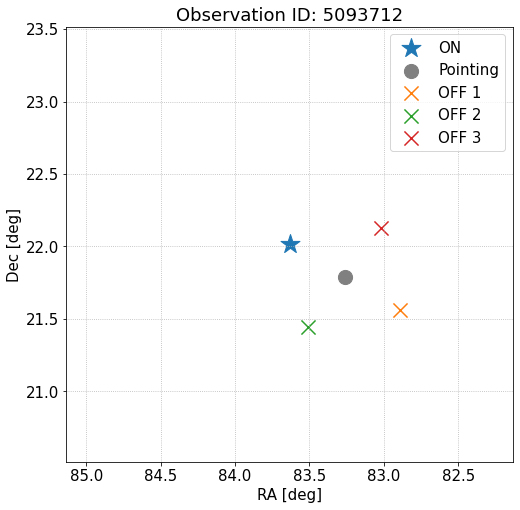

Observation ID: 5093713


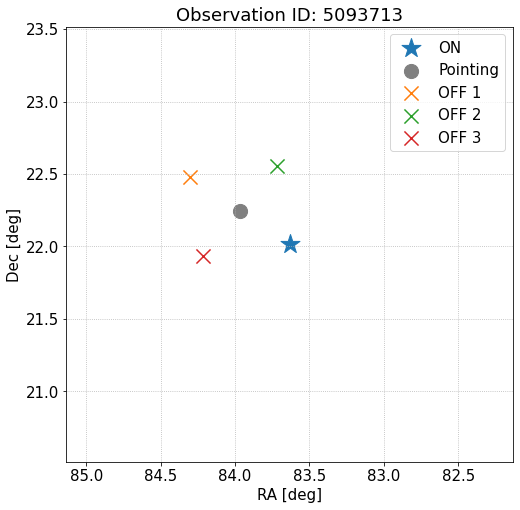

Observation ID: 5093714


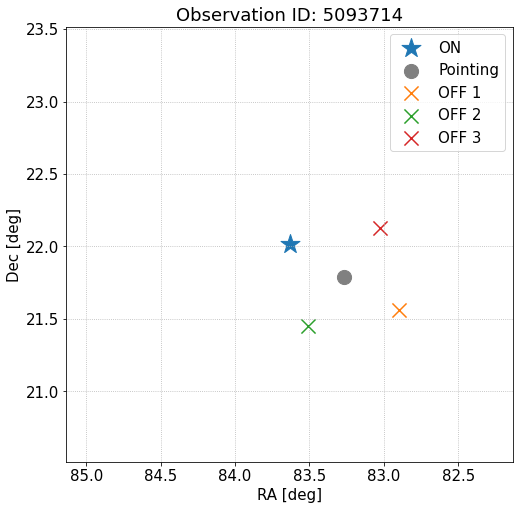

In [8]:
# ================
# === settings ===
# ================

source_name = 'Crab'
n_off_region = 3
half_width = u.Quantity(1.5, u.deg)

# ============
# === main ===
# ============

on_coord = SkyCoord.from_name(source_name)
on_coord = on_coord.transform_to('icrs')

xlim = [(on_coord.ra + half_width).value, (on_coord.ra - half_width).value]
ylim = [(on_coord.dec - half_width).value, (on_coord.dec + half_width).value]

observation_ids = np.unique(data_dl2.index.get_level_values('obs_id'))

for obs_id in observation_ids:
    
    print(f'Observation ID: {obs_id}')
    
    df = data_dl2.query(f'obs_id == {obs_id}')
    
    event_coords = SkyCoord(
        frame='icrs',
        ra=u.Quantity(df['reco_ra_mean'].to_numpy(), u.deg),
        dec=u.Quantity(df['reco_dec_mean'].to_numpy(), u.deg)
    )
    
    tel_coords = SkyCoord(
        frame='icrs',
        ra=u.Quantity(df['ra_tel_mean'].to_numpy(), u.deg),
        dec=u.Quantity(df['dec_tel_mean'].to_numpy(), u.deg) 
    )
    
    # --- calculate the angular separation ---
    theta_on, theta_off, off_coords = calc_angular_separation(
        on_coord, event_coords, tel_coords, n_off_region
    )
    
    data_dl2.loc[(obs_id, slice(None)), 'theta2_on'] = theta_on.to(u.deg).value**2
    
    for i_off in theta_off.keys():
        data_dl2.loc[(obs_id, slice(None)), f'theta2_off{i_off}'] = theta_off[i_off].to(u.deg).value**2
        
    # --- plot the coordinates ---
    pyplot.figure(figsize=(8, 8))
    pyplot.title(f'Observation ID: {obs_id}')
    pyplot.xlabel('RA [deg]')
    pyplot.ylabel('Dec [deg]')
    pyplot.xlim(xlim)
    pyplot.ylim(ylim)
    pyplot.axis(xlim+ylim)

    pyplot.scatter(
        on_coord.ra.value, on_coord.dec.value, label='ON', marker='*', s=400
    )

    pyplot.scatter(
        tel_coords.ra.mean().value, tel_coords.dec.mean().value,
        label='Pointing', marker='o', s=200, color='grey'
    )
    
    for i_off in off_coords.keys():
        
        pyplot.scatter(
            off_coords[i_off].ra.value, off_coords[i_off].dec.value, 
            label=f'OFF {i_off}', marker='x', s=200, color=color_cycle[i_off]
        )
    
    pyplot.grid()
    pyplot.legend()

    pyplot.show()
    pyplot.close()


# Check signal from source

### Function to find cuts to maximize the significance

In [9]:
def get_best_cuts_signif(data, bins_gamcut, bins_t2cut, n_off_region):
    
    print('Checking parameter cuts to maximize the significance...')
    
    n_bins_gamcut = len(bins_gamcut)
    n_bins_t2cut = len(bins_t2cut)

    bins_gamcut = np.repeat(bins_gamcut, n_bins_t2cut)
    bins_t2cut = np.tile(bins_t2cut, n_bins_gamcut)

    significances = []

    for gamcut, t2cut in zip(bins_gamcut, bins_t2cut):

        df = data.query(f'gammaness_mean > {gamcut}')

        n_on_obs = len(df.query(f'theta2_on < {t2cut}'))
        n_off_obs = np.sum([len(df.query(f'theta2_off{i_off+1} < {t2cut}')) for i_off in range(n_off_region)])

        alpha = 1/n_off_region

        stat = WStatCountsStatistic(n_on_obs, n_off_obs, alpha=alpha)
        signif = stat.sqrt_ts

        significances.append(signif)

    significances = np.array(significances)
    index_at_max = np.where(significances == significances.max())[0][0]

    gamcut_best = bins_gamcut[index_at_max]
    t2cut_best = bins_t2cut[index_at_max]
    
    return gamcut_best, t2cut_best

### Check theta2 distributions and significance

Checking parameter cuts to maximize the significance...

Parameter cuts: (gammaness, theta2) = (0.7, 0.02)

N_on = 1064
N_off = 584
alpha = 0.333

N_excess = 869.3
obs_time = 55.1 min
--> excess_rate = 15.8 [1 / min]

Li&Ma significance = 33.8 sigma



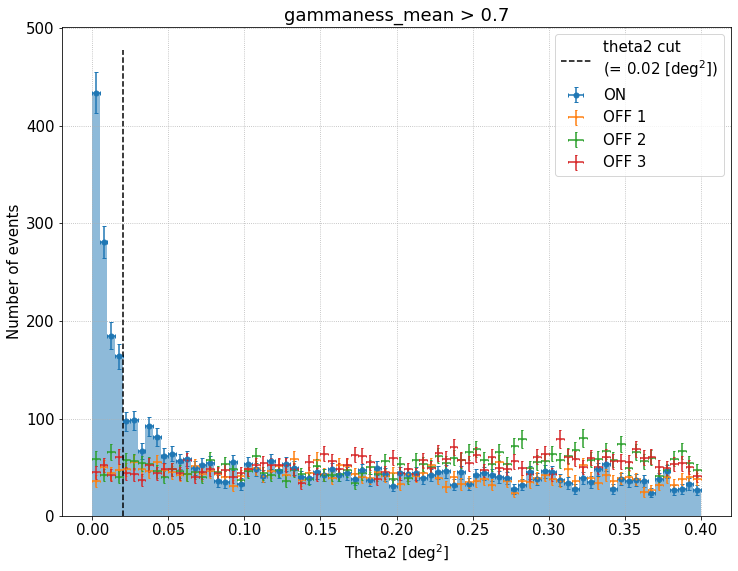

In [10]:
# ================
# === settings ===
# ================

df = pd.concat([
#     data_dl2.query('(event_type == 1) & (dist_sum < 0.22)'), 
#     data_dl2.query('(event_type == 2) & (dist_sum < 0.22)'), 
    data_dl2.query('(event_type == 3) & (dist_sum < 0.9)'),
])

bins_theta2 = np.linspace(0, 0.4, 81)

bins_gamcut = np.round(np.arange(0.5, 0.91, 0.05), 2)
bins_t2cut = np.round(np.arange(0.01, 0.051, 0.005), 3)
gamcut, t2cut = get_best_cuts_signif(df, bins_gamcut, bins_t2cut, n_off_region) 

# gamcut = 0.8
# t2cut = 0.03

# ============
# === main ===
# ============

print(f'\nParameter cuts: (gammaness, theta2) = ({gamcut}, {t2cut})')

df_gamcut = df.query(f'gammaness_mean > {gamcut}')

bins_center = (bins_theta2[:-1] + bins_theta2[1:])/2
xerr = [bins_center - bins_theta2[:-1], bins_theta2[1:] - bins_center]

# --- plot theta2 distributions --
pyplot.figure()
pyplot.title(f'gammaness_mean > {gamcut}')
pyplot.xlabel('Theta2 [deg$^2$]')
pyplot.ylabel('Number of events')

hist = pyplot.hist(df_gamcut['theta2_on'].to_numpy(), bins_theta2, histtype='bar', linewidth=2, alpha=0.5)[0]

pyplot.errorbar(
    x=bins_center, xerr=xerr, y=hist, yerr=np.sqrt(hist), 
    fmt='o', capsize=2, markersize=5, label='ON', color=color_cycle[0]
)

for i_off in range(n_off_region):
    
    hist, _ = np.histogram(df_gamcut[f'theta2_off{i_off+1}'].to_numpy(), bins_theta2)
    
    pyplot.errorbar(
        x=bins_center, xerr=xerr, y=hist, yerr=np.sqrt(hist), 
        fmt='o', capsize=1, markersize=1, label=f'OFF {i_off+1}'
    )
    
pyplot.plot(
    (t2cut, t2cut), (0, pyplot.ylim()[1]), 
    linestyle='--', color='black', label=f'theta2 cut\n(= {t2cut} [deg$^2$])'
)

pyplot.grid()
pyplot.legend()
    
# --- calculate the significance ---
times_first = df.groupby(['obs_id'])['timestamp'].first()
times_last = df.groupby(['obs_id'])['timestamp'].last()

obs_time = (times_last - times_first).sum()
obs_time = u.Quantity(obs_time, u.s)

n_on_obs = len(df_gamcut.query(f'theta2_on < {t2cut}'))
n_off_obs = np.sum([len(df_gamcut.query(f'theta2_off{i_off+1} < {t2cut}')) for i_off in range(n_off_region)])

alpha = 1/n_off_region
n_excess_obs = n_on_obs - alpha * n_off_obs
excess_rate = n_excess_obs/obs_time.to(u.min)

print(f'\nN_on = {n_on_obs}\nN_off = {n_off_obs}\nalpha = {alpha:.3f}')
print(f'\nN_excess = {n_excess_obs:.1f}\nobs_time = {obs_time.to(u.min):.1f}')
print(f'--> excess_rate = {excess_rate.value:.1f} [{excess_rate.unit}]')

stat = WStatCountsStatistic(n_on_obs, n_off_obs, alpha=alpha)
significance = stat.sqrt_ts
                        
print(f'\nLi&Ma significance = {significance:.1f} sigma\n')

### Check count map

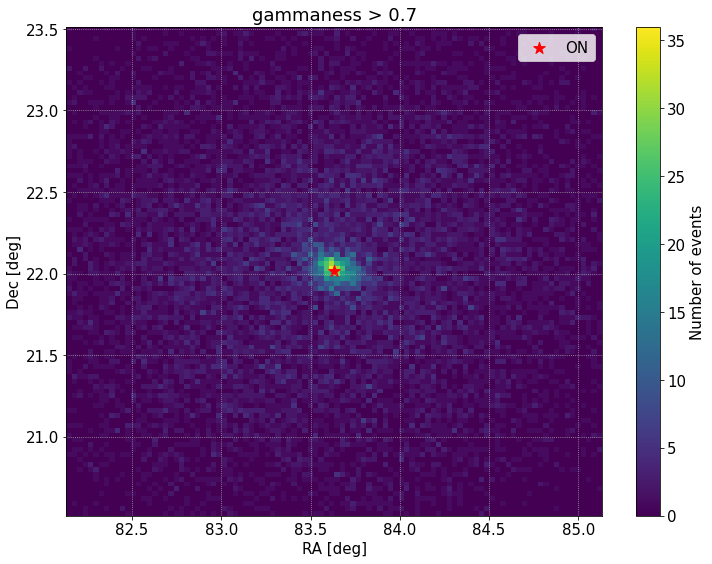

In [11]:
pyplot.figure()
pyplot.title(f'gammaness > {gamcut}')
pyplot.xlabel('RA [deg]')
pyplot.ylabel('Dec [deg]')
pyplot.xlim(xlim)
pyplot.ylim(ylim)
pyplot.axis(xlim+ylim)

bins_radec=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)]

pyplot.hist2d(df_gamcut['reco_ra_mean'].to_numpy(), df_gamcut['reco_dec_mean'].to_numpy(), bins=bins_radec)
pyplot.colorbar(label='Number of events')

pyplot.scatter(
    on_coord.ra.to(u.deg).value, on_coord.dec.to(u.deg).value, 
    label='ON', marker='*', s=150, color='red'
)

pyplot.legend()
pyplot.grid()